The goal of this notebook is to test the capability of an MLP to match some data.

1. First, a grid where 50% of the points are 0 and 50% are 1
2. Second, the same grid where 95% of the points are 0 and 5% are 1
3. Third, a sin(x) * sin(y) function

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
nelem_x = 50
nelem_y = 50

In [12]:
x = np.linspace(0,1,nelem_x)
y = np.linspace(0,1,nelem_y)

xx, yy = np.meshgrid(x,y)

In [13]:
df_data = pd.DataFrame()
df_data['X'] = xx.reshape(-1)
df_data['Y'] = yy.reshape(-1)

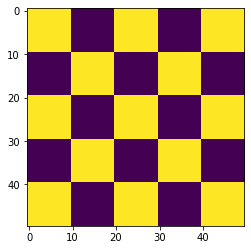

In [14]:
mask = np.zeros((nelem_x,nelem_y))

for i in range(0,nelem_x,20):
        for j in range(0,nelem_x,20):
            mask[i:i+10,j:j+10] = 1
            mask[i+10:i+20,j+10:j+20] = 1

plt.imshow(mask)

In [15]:
df_data['P_10'] = mask.reshape(-1)

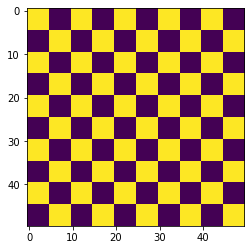

In [43]:
mask = np.zeros((nelem_x,nelem_y))

for i in range(0,nelem_x,10):
        for j in range(0,nelem_x,10):
            mask[i:i+5,j:j+5] = 1
            mask[i+5:i+10,j+5:j+10] = 1

plt.imshow(mask)

In [44]:
df_data['P_5'] = mask.reshape(-1)

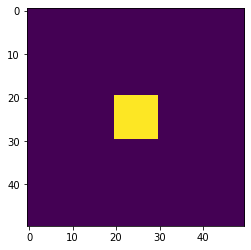

In [45]:
mask = np.zeros((nelem_x,nelem_y))

mask[20:30,20:30] = 1

plt.imshow(mask)

In [46]:
df_data['Sq'] = mask.reshape(-1)

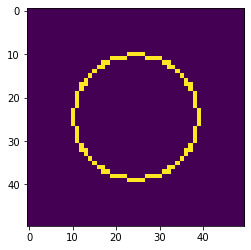

In [93]:
mask = np.zeros((nelem_x,nelem_y))

mask[np.sqrt((xx - 0.5) ** 2 + (yy - 0.5) ** 2) < 0.3] = 1

mask[np.sqrt((xx - 0.5) ** 2 + (yy - 0.5) ** 2) < 0.28] = 0

plt.imshow(mask)

In [94]:
df_data['Circ'] = mask.reshape(-1)

In [121]:
df_data['SinSin'] = (np.sin(4*np.pi*xx)*np.sin(4*np.pi*yy)).reshape(-1)

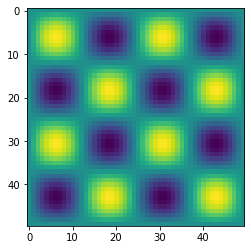

In [122]:
plt.imshow(np.sin(4*np.pi*xx)*np.sin(4*np.pi*yy))

In [95]:
# Analyse the proportions
print('### Size 5 ###')
for i in range(2):
    print("Label : {}, Number : {}".format(df_data['P_5'].value_counts().index[i],df_data['P_5'].value_counts().values[i]))

print('### Size 10 ###')
for i in range(2):
    print("Label : {}, Number : {}".format(df_data['P_10'].value_counts().index[i],df_data['P_10'].value_counts().values[i]))

print('### Square ###')
for i in range(2):
    print("Label : {}, Number : {}".format(df_data['Sq'].value_counts().index[i],df_data['Sq'].value_counts().values[i]))

print('### Circle ###')
for i in range(2):
    print("Label : {}, Number : {}".format(df_data['Circ'].value_counts().index[i],df_data['Circ'].value_counts().values[i]))

### Size 5 ###
Label : 0.0, Number : 1250
Label : 1.0, Number : 1250
### Size 10 ###
Label : 1.0, Number : 1300
Label : 0.0, Number : 1200
### Square ###
Label : 0.0, Number : 2400
Label : 1.0, Number : 100
### Circle ###
Label : 0.0, Number : 2412
Label : 1.0, Number : 88


In [96]:
import torch
import torch.nn as nn

In [97]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [99]:
class Model(nn.Module):
    def __init__(self,
                in_size = 2, 
                neurons_layer=[100, 100],
                out_size = 1
                ):
        """
        Initializing the PINN
        """
        nn.Module.__init__(self)

        self.layers = nn.ModuleList()

        # first layer
        self.layers.append(nn.Linear(in_features=in_size, out_features=neurons_layer[0])) 

        # hidden layers
        for n_in, n_out in zip(neurons_layer[:-1], neurons_layer[1:]):
            self.layers.append(nn.Linear(in_features=n_in, out_features=n_out))

        # output layer
        self.out  = nn.Linear(in_features=neurons_layer[-1], out_features=out_size)
        
        self.relu = nn.ReLU()

    def forward(self, x):
        """
        Forward Pass
        """
        for linear in self.layers:
            x = self.relu(linear(x))
        x = self.out(x)
        return x

In [100]:
def train(model,X_train,y_train,loss_fn,optimizer,epoch):
    model = model.to(device)

    x = torch.tensor(X_train[:, 0:1], requires_grad=True).float().to(device)
    y = torch.tensor(X_train[:, 1:2], requires_grad=True).float().to(device)

    true = torch.tensor(y_train).float().to(device)

    tot_loss = []
    for i in range(epoch):
        model.train()

        optimizer.zero_grad()

        preds = model(torch.cat([x, y], dim=1))

        loss = loss_fn(preds,true)
        loss.backward()
        optimizer.step()

        if i % 2000 == 0:
            print('Iter %d, Loss: %.5e' % (i,loss))

        tot_loss.append(loss)

    model.eval()

    preds = model(torch.cat([x, y], dim=1))
    preds = preds.detach().cpu().numpy()

    return model, preds, tot_loss

In [101]:
def plots(preds,true):
    # Compute error :
    error = preds-true

    # Plot :
    fig, ax = plt.subplots(1,3,figsize=(16,4))

    im = ax[0].imshow(preds.reshape(50,50))
    ax[0].set_title('Prediction')
    fig.colorbar(im, ax=ax[0])

    im = ax[1].imshow(true.reshape(50,50))
    ax[1].set_title('True')
    fig.colorbar(im, ax=ax[1])

    im = ax[2].imshow(error.reshape(50,50))
    ax[2].set_title('Error')
    fig.colorbar(im, ax=ax[2])

    plt.show()

In [102]:
model = Model()

loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

X_train = df_data.loc[:,['X','Y']].values
y_train = df_data.loc[:,['P_10']].values

epoch = 100000
model_trained_10, preds_10, loss_10 = train(model,X_train,y_train,loss_fn,optimizer,epoch)

Iter 0, Loss: 5.02855e-01
Iter 2000, Loss: 6.78722e-02
Iter 4000, Loss: 5.73517e-02
Iter 6000, Loss: 5.28650e-02
Iter 8000, Loss: 4.91201e-02
Iter 10000, Loss: 4.64308e-02
Iter 12000, Loss: 4.43021e-02
Iter 14000, Loss: 4.18842e-02
Iter 16000, Loss: 4.00275e-02
Iter 18000, Loss: 3.92050e-02
Iter 20000, Loss: 3.76040e-02
Iter 22000, Loss: 3.69883e-02
Iter 24000, Loss: 3.51653e-02
Iter 26000, Loss: 3.43128e-02
Iter 28000, Loss: 3.35666e-02
Iter 30000, Loss: 3.31164e-02
Iter 32000, Loss: 3.17879e-02
Iter 34000, Loss: 3.11422e-02
Iter 36000, Loss: 3.06700e-02
Iter 38000, Loss: 3.04598e-02
Iter 40000, Loss: 2.93085e-02
Iter 42000, Loss: 2.89951e-02
Iter 44000, Loss: 2.82990e-02
Iter 46000, Loss: 2.84374e-02
Iter 48000, Loss: 2.85803e-02
Iter 50000, Loss: 2.70157e-02
Iter 52000, Loss: 2.70922e-02
Iter 54000, Loss: 2.78548e-02
Iter 56000, Loss: 2.60741e-02
Iter 58000, Loss: 2.56316e-02
Iter 60000, Loss: 2.64053e-02
Iter 62000, Loss: 2.53002e-02
Iter 64000, Loss: 2.73458e-02
Iter 66000, Loss: 

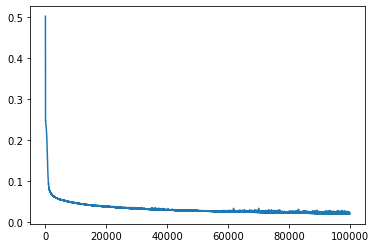

In [103]:
# plot loss
plt.plot(loss_10)

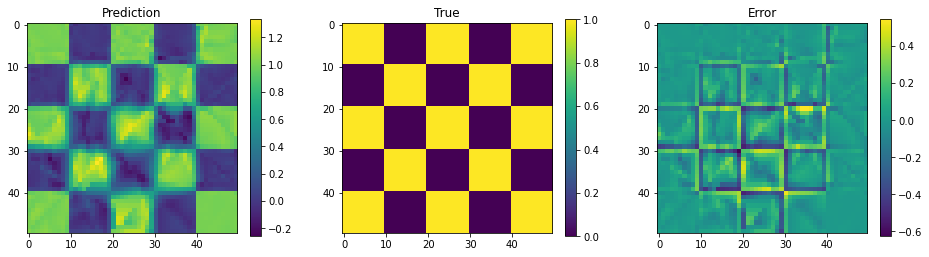

In [104]:
plots(preds_10,y_train)

In [105]:
model = Model()

loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

X_train = df_data.loc[:,['X','Y']].values
y_train = df_data.loc[:,['P_5']].values

epoch = 100000
model_trained_5, preds_5, loss_5 = train(model,X_train,y_train,loss_fn,optimizer,epoch)

Iter 0, Loss: 6.00869e-01
Iter 2000, Loss: 2.32933e-01
Iter 4000, Loss: 1.92535e-01
Iter 6000, Loss: 1.75783e-01
Iter 8000, Loss: 1.66573e-01
Iter 10000, Loss: 1.58822e-01
Iter 12000, Loss: 1.49296e-01
Iter 14000, Loss: 1.44298e-01
Iter 16000, Loss: 1.39535e-01
Iter 18000, Loss: 1.33561e-01
Iter 20000, Loss: 1.33591e-01
Iter 22000, Loss: 1.27024e-01
Iter 24000, Loss: 1.26737e-01
Iter 26000, Loss: 1.22354e-01
Iter 28000, Loss: 1.26327e-01
Iter 30000, Loss: 1.18339e-01
Iter 32000, Loss: 1.16441e-01
Iter 34000, Loss: 1.16353e-01
Iter 36000, Loss: 1.15214e-01
Iter 38000, Loss: 1.12674e-01
Iter 40000, Loss: 1.11626e-01
Iter 42000, Loss: 1.10042e-01
Iter 44000, Loss: 1.07244e-01
Iter 46000, Loss: 1.13842e-01
Iter 48000, Loss: 1.06945e-01
Iter 50000, Loss: 1.04644e-01
Iter 52000, Loss: 1.03610e-01
Iter 54000, Loss: 1.02278e-01
Iter 56000, Loss: 1.01265e-01
Iter 58000, Loss: 9.84631e-02
Iter 60000, Loss: 9.93833e-02
Iter 62000, Loss: 9.60956e-02
Iter 64000, Loss: 9.65430e-02
Iter 66000, Loss: 

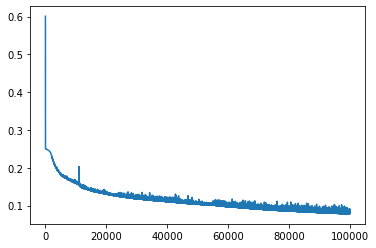

In [106]:
# plot loss
plt.plot(loss_5)

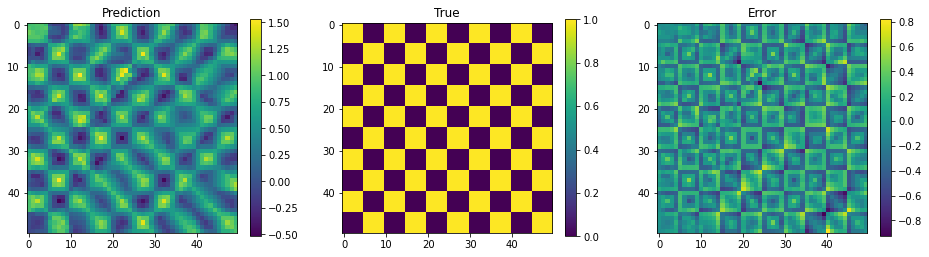

In [107]:
plots(preds_5,y_train)

In [108]:
model = Model()

loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

X_train = df_data.loc[:,['X','Y']].values
y_train = df_data.loc[:,['Sq']].values

epoch = 100000
model_trained_Sq, preds_Sq, loss_Sq = train(model,X_train,y_train,loss_fn,optimizer,epoch)

Iter 0, Loss: 4.43822e-02
Iter 2000, Loss: 3.82719e-03
Iter 4000, Loss: 1.84991e-03
Iter 6000, Loss: 5.35936e-04
Iter 8000, Loss: 2.03849e-04
Iter 10000, Loss: 1.10635e-04
Iter 12000, Loss: 3.64636e-04
Iter 14000, Loss: 6.88061e-05
Iter 16000, Loss: 1.14823e-04
Iter 18000, Loss: 3.15331e-04
Iter 20000, Loss: 3.62004e-05
Iter 22000, Loss: 2.95986e-05
Iter 24000, Loss: 2.68208e-05
Iter 26000, Loss: 2.34725e-05
Iter 28000, Loss: 5.84021e-05
Iter 30000, Loss: 4.19905e-05
Iter 32000, Loss: 2.77968e-05
Iter 34000, Loss: 2.62934e-05
Iter 36000, Loss: 4.51088e-04
Iter 38000, Loss: 2.06683e-05
Iter 40000, Loss: 3.14198e-05
Iter 42000, Loss: 3.13437e-05
Iter 44000, Loss: 1.31013e-05
Iter 46000, Loss: 1.20543e-05
Iter 48000, Loss: 5.46237e-05
Iter 50000, Loss: 1.00700e-04
Iter 52000, Loss: 9.34836e-06
Iter 54000, Loss: 5.95782e-05
Iter 56000, Loss: 2.04075e-05
Iter 58000, Loss: 9.79598e-05
Iter 60000, Loss: 2.12639e-04
Iter 62000, Loss: 3.60433e-05
Iter 64000, Loss: 1.86370e-05
Iter 66000, Loss: 

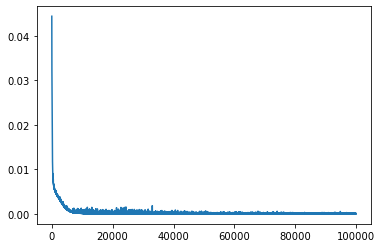

In [109]:
# plot loss
plt.plot(loss_Sq)

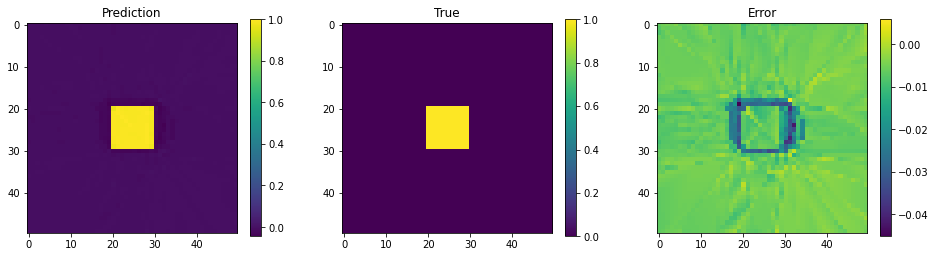

In [110]:
plots(preds_Sq,y_train)

In [111]:
model = Model()

loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

X_train = df_data.loc[:,['X','Y']].values
y_train = df_data.loc[:,['Circ']].values

epoch = 100000
model_trained_Circ, preds_Circ, loss_Circ = train(model,X_train,y_train,loss_fn,optimizer,epoch)

Iter 0, Loss: 3.40714e-02
Iter 2000, Loss: 2.32711e-02
Iter 4000, Loss: 2.03330e-02
Iter 6000, Loss: 1.76750e-02
Iter 8000, Loss: 1.63437e-02
Iter 10000, Loss: 1.44728e-02
Iter 12000, Loss: 1.30328e-02
Iter 14000, Loss: 1.19258e-02
Iter 16000, Loss: 1.11320e-02
Iter 18000, Loss: 1.08599e-02
Iter 20000, Loss: 1.01404e-02
Iter 22000, Loss: 9.83960e-03
Iter 24000, Loss: 9.39563e-03
Iter 26000, Loss: 9.61151e-03
Iter 28000, Loss: 8.84691e-03
Iter 30000, Loss: 9.04628e-03
Iter 32000, Loss: 8.54158e-03
Iter 34000, Loss: 9.13840e-03
Iter 36000, Loss: 8.01642e-03
Iter 38000, Loss: 8.45556e-03
Iter 40000, Loss: 7.79379e-03
Iter 42000, Loss: 7.55304e-03
Iter 44000, Loss: 7.54952e-03
Iter 46000, Loss: 7.29745e-03
Iter 48000, Loss: 7.74402e-03
Iter 50000, Loss: 7.35562e-03
Iter 52000, Loss: 7.09333e-03
Iter 54000, Loss: 7.91349e-03
Iter 56000, Loss: 6.67920e-03
Iter 58000, Loss: 7.05833e-03
Iter 60000, Loss: 6.97341e-03
Iter 62000, Loss: 6.38478e-03
Iter 64000, Loss: 6.61359e-03
Iter 66000, Loss: 

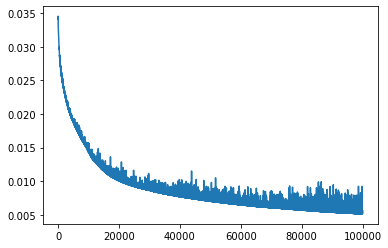

In [112]:
# plot loss
plt.plot(loss_Circ)

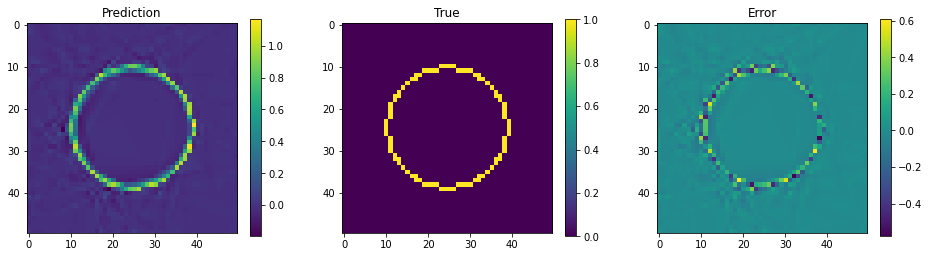

In [113]:
plots(preds_Circ,y_train)

In [123]:
model = Model()

loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

X_train = df_data.loc[:,['X','Y']].values
y_train = df_data.loc[:,['SinSin']].values

epoch = 100000
model_trained_SinSin, preds_SinSin, loss_SinSin = train(model,X_train,y_train,loss_fn,optimizer,epoch)

Iter 0, Loss: 2.54865e-01
Iter 2000, Loss: 1.33153e-03
Iter 4000, Loss: 7.76789e-04
Iter 6000, Loss: 9.17941e-04
Iter 8000, Loss: 5.04899e-04
Iter 10000, Loss: 3.32384e-03
Iter 12000, Loss: 4.27908e-04
Iter 14000, Loss: 5.52600e-04
Iter 16000, Loss: 8.39244e-04
Iter 18000, Loss: 3.72097e-04
Iter 20000, Loss: 3.44195e-04
Iter 22000, Loss: 5.78964e-04
Iter 24000, Loss: 3.21891e-04
Iter 26000, Loss: 3.08908e-04
Iter 28000, Loss: 2.97940e-04
Iter 30000, Loss: 2.91012e-04
Iter 32000, Loss: 2.86358e-04
Iter 34000, Loss: 1.42053e-03
Iter 36000, Loss: 2.80567e-04
Iter 38000, Loss: 2.83984e-04
Iter 40000, Loss: 2.27966e-04
Iter 42000, Loss: 2.09632e-04
Iter 44000, Loss: 2.01798e-04
Iter 46000, Loss: 2.00178e-04
Iter 48000, Loss: 1.93844e-04
Iter 50000, Loss: 2.02372e-04
Iter 52000, Loss: 1.84440e-04
Iter 54000, Loss: 1.79414e-04
Iter 56000, Loss: 1.76053e-04
Iter 58000, Loss: 1.73225e-04
Iter 60000, Loss: 2.09381e-04
Iter 62000, Loss: 2.19466e-04
Iter 64000, Loss: 1.64284e-04
Iter 66000, Loss: 

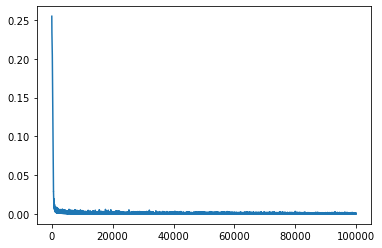

In [124]:
# plot loss
plt.plot(loss_SinSin)

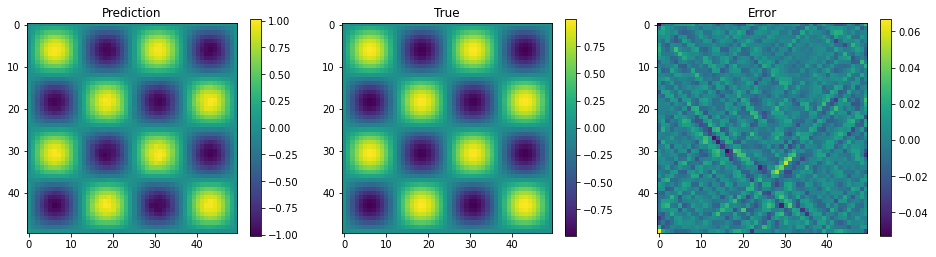

In [125]:
plots(preds_SinSin,y_train)